# Fig. S5 MPSA Analysis for ELP1 exon 20


In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logomaker as lm
import re
import mplcursors  # for interactive plotting
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon

# My functions
import utils

# Useful variables
e = np.exp(1)
idx = pd.IndexSlice
_ = np.newaxis

# For displaying figures
%matplotlib inline

In [2]:
# Define plot style
style_file_name = 'fig.style'
s = """
axes.linewidth:     1.0     # edge linewidth
font.size:          7.0  
axes.labelsize:     7.0  # fontsize of the x any y labels
axes.titlesize:     7.0  # fontsize of the titles
xtick.labelsize:    7.0  # fontsize of the xtick labels
ytick.labelsize:    7.0  # fontsize of the ytick labels
legend.fontsize:      7.0
legend.borderpad:     0.2  # border whitespace
legend.labelspacing:  0.2  # the vertical space between the legend entries
legend.borderaxespad: 0.2  # the border between the axes and legend edge
axes.labelpad:      1.0     # space between label and axis
figure.dpi: 600
"""
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# # Remove all .pdf files
# !rm *.pdf

In [4]:
# Set known motifs ELP1
wt_motif   = 'AGGA/GUAAGU'
cons_motif = 'ACAG/GUAAGU'
null_motif = 'ACAG/GGAAGA'
ris_min_motif = 'ANGA/GUADGN'
ris_max_motif = 'ANGA/GUHDNN'
hyp_min_motif = 'NAGA/GURNGN'
hyp_max_motif = 'NANN/GUNNNN'

In [5]:
# Load all data
# Normalize by median of consensus sequences

# Set file names
filenames = ['psi_elp1_dmso.csv',
             'psi_elp1_rg.csv',
             'psi_elp1_nvs.csv',]
filenames = ['../data/mpsa/'+f for f in filenames]

# Create container to hold data
psi_df = pd.DataFrame()

# Load SMN2 data
locus = 'elp1'
locus_filenames = [name for name in filenames if locus in name]
for i, filename in enumerate(locus_filenames):
    col = filename.split('/')[-1].split('.')[0][4:]
    tmp_df = pd.read_csv(filename, sep=',')

    # Rename splice sites
    tmp_df['ss'] = [s.replace('T','U') for s in tmp_df['ss']]
    tmp_df['ss'] = ['A'+s[:3]+'/'+s[3:] for s in tmp_df['ss']]
    tmp_df = tmp_df.set_index('ss')

    # Normalize each replicate by the median PSI of the 4 consensus sequences
    cons_ix = utils.motif_to_ix(cons_motif, tmp_df.index)
    cons_psi = tmp_df[cons_ix].median(axis=0)
    tmp_df.loc[:,:] = 100*tmp_df.values/cons_psi.values

    # Take median PSIs across columns
    if i==0:
        out_df = pd.DataFrame(index=tmp_df.index)
    out_df[col] = tmp_df.median(axis=1)

# Normalize AGAIN by median PSI
cons_ix = utils.motif_to_ix(cons_motif, out_df.index)
cons_psi = out_df[cons_ix].median(axis=0)
out_df.loc[:,:] = 100*out_df.values/cons_psi.values

# Verify that median PSI of consensus sequences is 100.0
cons_ix = utils.motif_to_ix(cons_motif, out_df.index)
assert(np.all(out_df[cons_ix].median(axis=0) == 100))

# Merge into psi_df
psi_df = pd.merge(left=psi_df, 
                  left_index=True, 
                  right=out_df, 
                  right_index=True, 
                  how='outer')
    
# Set sequences
seqs = psi_df.index.values

# Set known motif indices and view quantities
wt_ix = utils.motif_to_ix(wt_motif, seqs)
cons_ix = utils.motif_to_ix(cons_motif, seqs) 
null_ix = utils.motif_to_ix(null_motif, seqs)

print(f'Num wildtype seqs: {sum(wt_ix)} ')
print(f'Num cons seqs: {sum(cons_ix)} ')
print(f'Num null seqs: {sum(null_ix)} ')

print(f'N: {len(psi_df)}')
psi_df.head()

Num wildtype seqs: 1 
Num cons seqs: 1 
Num null seqs: 0 
N: 30807


,elp1_dmso,elp1_rg,elp1_nvs
ss,,,
AAAA/GCAAAA,0.0,0.025349,0.108121
AAAA/GCAAAG,0.0,0.000000,0.000000
AAAA/GCAAGA,0.0,0.000000,0.000000
AAAA/GCAAGG,0.0,0.004373,0.000000
AAAA/GCAAUC,0.0,0.000000,0.000000


In [6]:
# Define function to plot results
s = 20
bulkalpha=.5
si_figsize = [3.25,3.25]
figsize = [2,2]
N = len(seqs)
lims = [1E-4, 2E3]

# Shared ax style
def style_ax(ax, xlabel=None, ylabel=None):
    ticks = [3E-4, 1E-2, 1E0,  1E2]
    ticklabels = ['0', '$10^{-2}$', '$10^{0}$', '$10^{2}$']
    
    ax.axhline(100, linestyle='--', color='k', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.axvline(100, linestyle='--', color='k', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.plot(lims, lims, 'k:', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticklabels)
    ax.set_yticklabels(ticklabels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal')
    ax.minorticks_off()
    ax.legend(loc='lower right', framealpha=1, fontsize=6)

In [7]:
def draw(ax, xcol, ycol, xlabel, ylabel, ris_motif, hyp_motif, ris_motif_color, hyp_motif_color, 
         ris_motif_name=None, hyp_motif_name=None, legend=False):
    s=10
    bulkalpha=.2
    x = psi_df[xcol]
    y = psi_df[ycol]
    
    # Get indices
    seqs = psi_df.index.values
    wt_ix = utils.motif_to_ix(wt_motif, seqs)
    ris_ix = utils.motif_to_ix(ris_motif, seqs)
    hyper_ix = utils.motif_to_ix(hyp_motif, seqs)
    
    # Add lim
    zero_lo = lims[0]
    zero_hi = lims[0]*10
    x = x + (x==0)*zero_lo*((zero_hi/zero_lo)**np.random.rand(len(x)))
    y = y + (y==0)*zero_lo*((zero_hi/zero_lo)**np.random.rand(len(y)))
    ax.scatter(x, y, alpha=bulkalpha, s=s, linewidth=0, color='silver', rasterized=True, zorder=-80)
    ax.scatter(x[ris_ix], y[ris_ix], alpha=1, s=s, linewidth=0, 
               facecolor=ris_motif_color, label=ris_motif_name, rasterized=True)
    ax.scatter(x[hyper_ix], y[hyper_ix], alpha=1, s=1.5*s, linewidth=1, edgecolor=hyp_motif_color, 
               facecolor='none', label=hyp_motif_name, rasterized=True, zorder=-50)
    ax.scatter(x[wt_ix], y[wt_ix], alpha=1, s=s/4, linewidth=0, color='k', rasterized=True)
    ax.axvline(zero_hi, linestyle=':', color='k', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    ax.axhline(zero_hi, linestyle=':', color='k', alpha=.2, zorder=-100, linewidth=.5, rasterized=True)
    style_ax(ax, xlabel=xlabel, ylabel=ylabel)
    if not legend:
        ax.get_legend().remove()
    else:
        ax.legend(fontsize=6, loc='upper left')

Figure saved to figS5.pdf


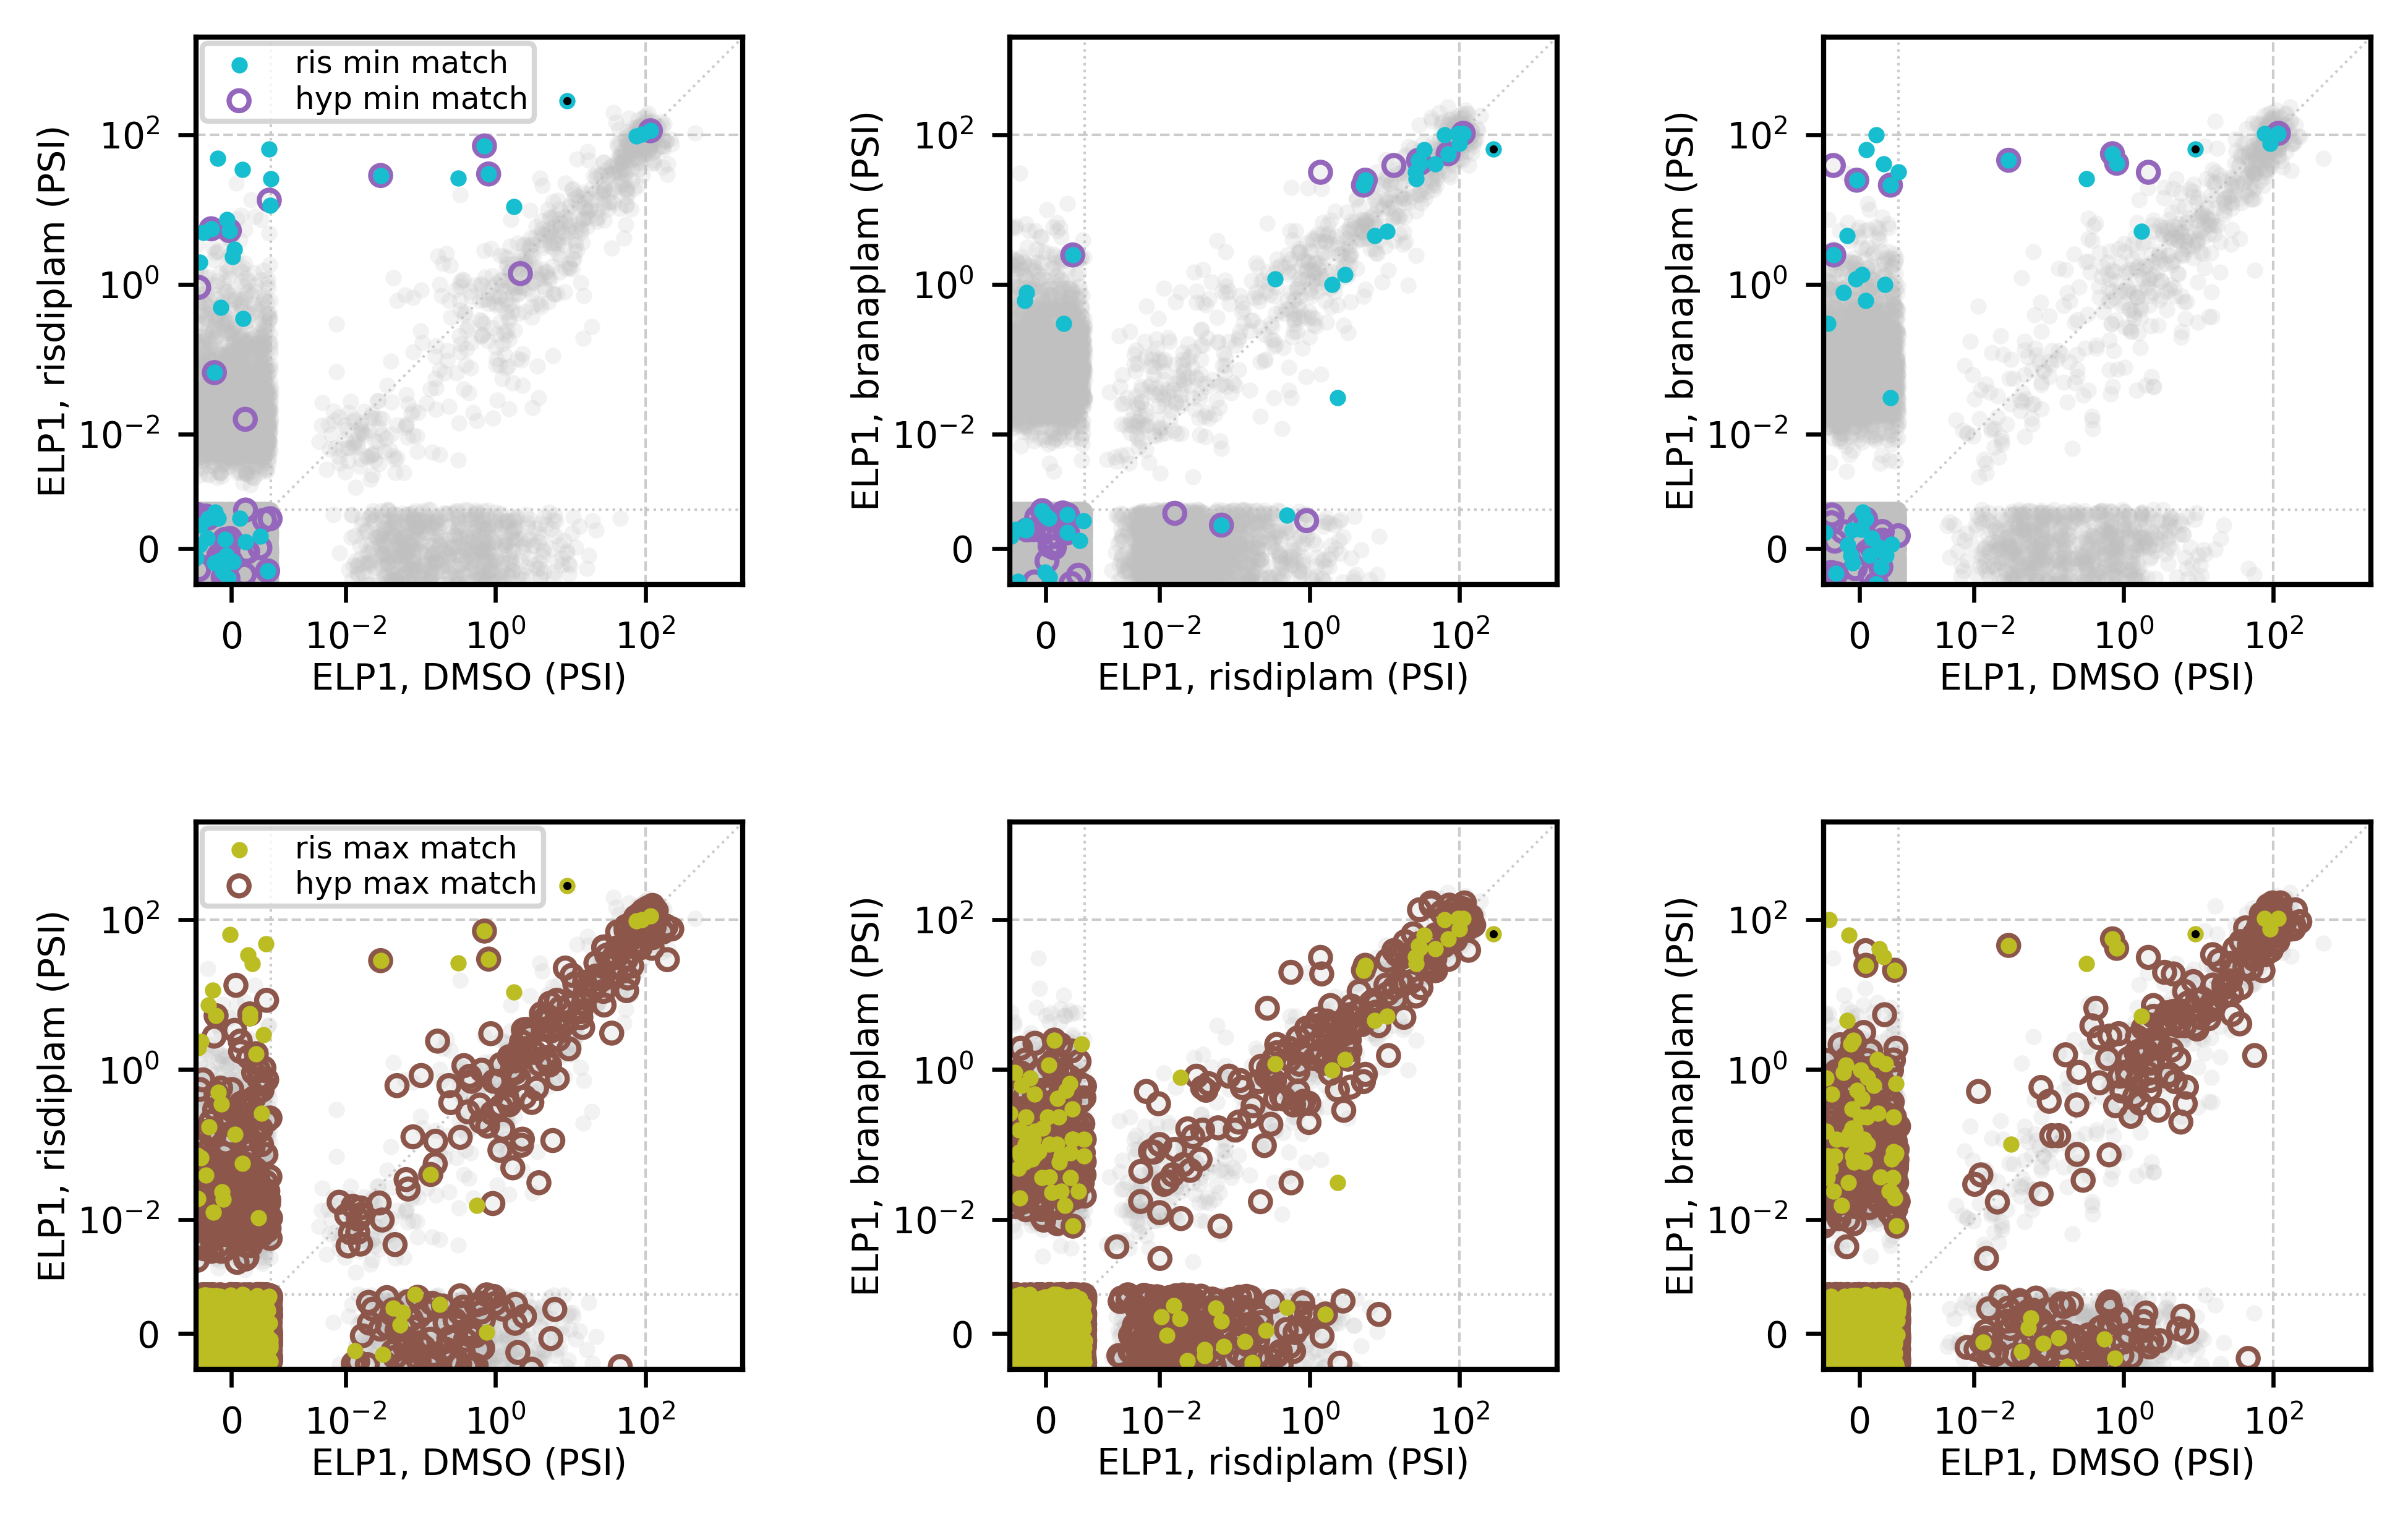

In [8]:
# Make figure
fig= plt.figure(figsize=[6.5, 4.25])
gs = GridSpec(2, 3)

min_kwargs = dict(
     ris_motif=ris_min_motif,
     hyp_motif=hyp_min_motif,
     ris_motif_color='C9',
     hyp_motif_color='C4',
     ris_motif_name='ris min match',
     hyp_motif_name='hyp min match',
)

max_kwargs = dict(
     ris_motif=ris_max_motif,
     hyp_motif=hyp_max_motif,
     ris_motif_color='C8',
     hyp_motif_color='C5',
     ris_motif_name='ris max match',
     hyp_motif_name='hyp max match',
)

# A
draw(ax=fig.add_subplot(gs[0,0]),
     xcol='elp1_dmso', 
     ycol='elp1_rg', 
     xlabel='ELP1, DMSO (PSI)',
     ylabel='ELP1, risdiplam (PSI)',
     legend=True,
     **min_kwargs)

# B
draw(ax=fig.add_subplot(gs[0,1]),
     xcol='elp1_rg', 
     ycol='elp1_nvs', 
     xlabel='ELP1, risdiplam (PSI)',
     ylabel='ELP1, branaplam (PSI)',
     legend=False,
     **min_kwargs)

# C
draw(ax=fig.add_subplot(gs[0,2]),
     xcol='elp1_dmso', 
     ycol='elp1_nvs', 
     xlabel='ELP1, DMSO (PSI)',
     ylabel='ELP1, branaplam (PSI)',
     legend=False,
     **min_kwargs)

# D
draw(ax=fig.add_subplot(gs[1,0]),
     xcol='elp1_dmso', 
     ycol='elp1_rg', 
     xlabel='ELP1, DMSO (PSI)',
     ylabel='ELP1, risdiplam (PSI)',
     legend=True,
     **max_kwargs)

# E
draw(ax=fig.add_subplot(gs[1,1]),
     xcol='elp1_rg', 
     ycol='elp1_nvs', 
     xlabel='ELP1, risdiplam (PSI)',
     ylabel='ELP1, branaplam (PSI)',
     legend=False,
     **max_kwargs)

# F
draw(ax=fig.add_subplot(gs[1,2]),
     xcol='elp1_dmso', 
     ycol='elp1_nvs', 
     xlabel='ELP1, DMSO (PSI)',
     ylabel='ELP1, branaplam (PSI)',
     legend=False,
     **max_kwargs)
        
# Save figure
plt.tight_layout(w_pad=3, h_pad=2)
fig_name = 'figS5.pdf'
fig.savefig(fig_name)
print(f'Figure saved to {fig_name}')


In [9]:
# Find ris max motif false positives:
xcol='elp1_dmso' 
ycol='elp1_rg'
x = psi_df[xcol]
y = psi_df[ycol]
ris_ix = utils.motif_to_ix(ris_max_motif, seqs)

ix = (x > 0.003) & (y > 0.003) & (x < 50) & (y < 50) & (y < x) & ris_ix
psi_df[ix]

,elp1_dmso,elp1_rg,elp1_nvs
ss,,,
AAGA/GUUGAC,0.136423,0.039919,0.0
AUGA/GUAUAA,0.558407,0.015279,0.0
